# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries for Spark Session
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [3]:
# import libraries for sql actions
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

In [4]:
# other non-spark libraries

import datetime
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Spark ML libraries

from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler

In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [7]:
# view information about spark configuration
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '9e072a92ba60'),
 ('spark.app.id', 'local-1609012951358'),
 ('spark.driver.port', '44435'),
 ('spark.ui.showConsoleProgress', 'true')]

In [8]:
# view information about spark session
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
# define path and load data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# check schema of object
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# take first five elements
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [12]:
# show first few rows
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [13]:
# look at statistics of column 'artist' (numbers don't make sense as no numerical datatype)
user_log.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [14]:
# look at statistics of column 'sessionId'
user_log.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [15]:
# show unique possible values of column 'page'
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [15]:
# count rows 
user_log.count()

286500

In [17]:
# look at example with missing values
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album Version)'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Dog Days Are Over (Radio Edit)'),
 Row(userId='30', firstname='Coli

### Calculating Statistics by Hour

In [18]:
# create user defined function to convert the ts column into hour format
get_hour = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp / 1000.0). hour)

In [19]:
# create new column "hour" by applying udf get_hour
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [20]:
# check if hour column present in first record
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [21]:
# take only amount of action "NextSong" and group it by hour of day
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(
    user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [22]:
# show resulting table
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [23]:
# convert spark object ot pandas dataframe
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

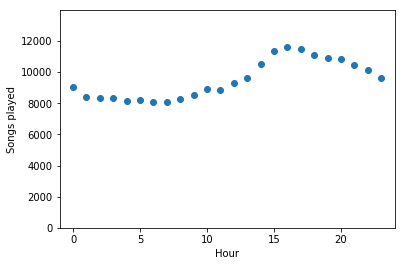

In [24]:
# plot the amount of songs played over hours of day
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

### Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [25]:
# drop any record with NANs in user ID OR session ID and save to new object
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [26]:
# check amount of  records
user_log_valid.count()

286500

In [27]:
# show unique user IDs
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [28]:
# drop empty user IDs
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [29]:
# check if now less than 286500 records
user_log_valid.count()

278154

### Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [30]:
# show records where downgrade was submitted (churn)
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  11|
|  null|Logged In|   Calvin|     M|           17| Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38| 

In [40]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "30").collect()

[Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Rockpools'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Time For Miracles'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Harder Better Faster Stronger'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Passengers (Old Album Version)'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', level='paid', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Fuck Kitty'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Jade'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='So-Called Friends'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Represent'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Here I Am'),
 Row(userId='30', firstname='Colin', page='NextSong', level='paid', song='Reb

In [32]:
# user defined function to flag the events page=submit downgrade with extra column
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [33]:
# create extrac column "downgraded"
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [34]:
# check if column existst
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', downgraded=0)

In [35]:
# import window function
from pyspark.sql import Window

In [36]:
# create window function and group by user ID orderd after reverse time, take into account previous rows
# -> Window.unboundedPreceding, but now rows after ->0
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [37]:
# create column where all events before downgrade have phase=1 and all events after have events=0
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [42]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase", "downgraded"]).where(user_log.userId == "30").sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353218000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353441000, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', firstname='Colin', ts=1538353687000, page='NextSong', level='paid', phase=1, downgraded=0),
 Ro

In [46]:
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = user_log.filter((user_log.page == 'NextSong') | (user_log.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+



In [48]:
# How many songs were played from the most played artist?

user_log.filter(user_log.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+-------------+-----------+
|       Artist|Artistcount|
+-------------+-----------+
|Kings Of Leon|       1841|
+-------------+-----------+
only showing top 1 row



In [49]:
# How many female users do we have in the data set?

user_log.filter(user_log.gender == 'F').select('userId', 'gender').dropDuplicates().count()

104

In [50]:
# Which page did user id "" (empty string) NOT visit?

# filter for users with blank user id
blank_pages = user_log.filter(user_log.userId == '').select(col('page').alias('blank_pages')).dropDuplicates()

# get a list of possible pages that could be visited
all_pages = user_log.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Cancellation Confirmation
Submit Downgrade
Thumbs Down
Roll Advert
Cancel
Logout
Upgrade
Downgrade
Submit Upgrade
Add Friend
Add to Playlist
Thumbs Up
Save Settings
NextSong
Settings


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.